### Given Problem

Users data is given for 12,000 users for some online product. The data also includes the dates when the user logged into the product.

A user is "adopted" when he/she has logged into the system at least 3 days within some 7 day period.

Goal is to identify factors that predict future user adoption.

### Solution Approach

First we should find the adopted users with the given data.

Explore the data to see how various data columns relate to the adopted user column. Visualize the data.

Devise new features if possible that could explain adopted user flag better.

Fit the data using machine learning models.

Use the models to find out the best features.

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
%matplotlib inline

In [5]:
eng_df = pd.read_csv("takehome_user_engagement.csv",parse_dates=True,skipfooter=1,engine="python")

In [6]:
eng_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [7]:
# We can see from above that only the date part of timestamp is relevant. So we can covert that into only dates.

In [8]:
type(eng_df.time_stamp[0])

str

In [9]:
eng_df.time_stamp = [pd.to_datetime(item).date() for item in eng_df.time_stamp]

In [10]:
eng_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207916 entries, 0 to 207915
Data columns (total 3 columns):
time_stamp    207916 non-null object
user_id       207916 non-null int64
visited       207916 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [11]:
eng_df.user_id = eng_df.user_id.astype('int64')

In [12]:
eng_df.user_id.unique().size

8822

In [13]:
# finding out adopted users:
# get columns for each user to correspond to different dates
# get a continuous date time series
# using window operations find out if the users have 3 logins (1's) within 7 day running periods
# also preserve data for later use

In [14]:
# group by dates and collect users visiting that day
df1 = eng_df.groupby(by='time_stamp').apply(lambda x: list(x.user_id))

In [15]:
df1.head()

time_stamp
2012-05-31                            [1693, 3428, 9899, 10012]
2012-06-01              [1995, 6102, 8068, 10163, 10922, 11430]
2012-06-02    [2120, 3514, 3721, 4584, 7170, 7286, 9394, 112...
2012-06-03    [563, 2136, 2494, 2568, 3861, 5694, 6047, 7991...
2012-06-04    [1551, 2973, 3023, 3514, 4426, 4510, 6618, 717...
dtype: object

In [16]:
df1 = pd.DataFrame(df1,columns=["userlist"])

In [17]:
df1.head()

,userlist
time_stamp,
2012-05-31,"[1693, 3428, 9899, 10012]"
2012-06-01,"[1995, 6102, 8068, 10163, 10922, 11430]"
2012-06-02,"[2120, 3514, 3721, 4584, 7170, 7286, 9394, 112..."
2012-06-03,"[563, 2136, 2494, 2568, 3861, 5694, 6047, 7991..."
2012-06-04,"[1551, 2973, 3023, 3514, 4426, 4510, 6618, 717..."


In [18]:
df1.shape, df1.index.min(),df1.index.max()

((736, 1), datetime.date(2012, 5, 31), datetime.date(2014, 6, 6))

In [19]:
df1.tail()

,userlist
time_stamp,
2014-06-01,"[10, 59, 63, 82, 135, 185, 197, 200, 203, 209,..."
2014-06-02,"[10, 63, 82, 135, 146, 185, 203, 209, 214, 221..."
2014-06-03,"[10, 63, 82, 146, 185, 203, 209, 214, 221, 230..."
2014-06-04,"[63, 82, 146, 185, 200, 203, 230, 263, 297, 31..."
2014-06-06,[4051]


In [20]:
# looks like one day missing its 736 but should be 737
# let us create a time series and see what date is missing
ts = pd.date_range(start="2012-05-31",end="2014-06-06",freq="D")

In [21]:
set(ts.date) - set(df1.index.values)

{datetime.date(2014, 6, 5)}

In [22]:
# we see that none of the users logged in on date(2014, 6, 5) 
# and we can add one missing date row 
df1.loc[pd.to_datetime("2014-06-05").date(),"userlist"] = []

In [23]:
df1.head(), df1.shape

(                                                     userlist
 time_stamp                                                   
 2012-05-31                          [1693, 3428, 9899, 10012]
 2012-06-01            [1995, 6102, 8068, 10163, 10922, 11430]
 2012-06-02  [2120, 3514, 3721, 4584, 7170, 7286, 9394, 112...
 2012-06-03  [563, 2136, 2494, 2568, 3861, 5694, 6047, 7991...
 2012-06-04  [1551, 2973, 3023, 3514, 4426, 4510, 6618, 717..., (737, 1))

In [24]:
df1.tail()

,userlist
time_stamp,
2014-06-02,"[10, 63, 82, 135, 146, 185, 203, 209, 214, 221..."
2014-06-03,"[10, 63, 82, 146, 185, 203, 209, 214, 221, 230..."
2014-06-04,"[63, 82, 146, 185, 200, 203, 230, 263, 297, 31..."
2014-06-06,[4051]
2014-06-05,[]


In [25]:
# columns for each user with deafault visit as 0
df2 = pd.DataFrame(index=df1.index,columns=eng_df.user_id.unique(),data=np.zeros((df1.shape[0],eng_df.user_id.unique().size)))

In [26]:
df2.shape

(737, 8822)

In [27]:
# join with df1
df3 = df1.join(df2)

In [28]:
df3.shape

(737, 8823)

In [29]:
df3.head()

,userlist,1,2,3,4,5,6,7,10,11,...,11988,11989,11990,11991,11992,11995,11996,11997,11998,11999
time_stamp,,,,,,,,,,,,,,,,,,,,,
2012-05-31,"[1693, 3428, 9899, 10012]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-06-01,"[1995, 6102, 8068, 10163, 10922, 11430]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-06-02,"[2120, 3514, 3721, 4584, 7170, 7286, 9394, 112...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-06-03,"[563, 2136, 2494, 2568, 3861, 5694, 6047, 7991...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-06-04,"[1551, 2973, 3023, 3514, 4426, 4510, 6618, 717...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
df3.shape

(737, 8823)

In [31]:
for idx,row in df3.iterrows():
    for userid in row["userlist"]:
        df3.loc[idx,userid] = 1

In [32]:
df3.loc[:,1693][0]

1.0

In [33]:
# we dont need userlist column anymore
df4 = df3.drop("userlist",axis=1)
df4 = df4.sort_index()
df4.tail()

,1,2,3,4,5,6,7,10,11,13,...,11988,11989,11990,11991,11992,11995,11996,11997,11998,11999
time_stamp,,,,,,,,,,,,,,,,,,,,,
2014-06-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-06-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-06-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-06-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-06-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# now let us get a window of 7 continuous days and 
# collect all the users and retain only those users that are present 3 or more times
r = df4.rolling(window=7)

In [35]:
df5 = r.sum()

In [36]:
adopted_users = set([])

In [37]:
for col in df5.columns:
    if any(df5[col] >= 3):
        adopted_users.add(col)

In [38]:
# here are the adopted users
len(adopted_users)

1602

In [39]:
sorted(adopted_users)

[2,
 10,
 20,
 33,
 42,
 43,
 50,
 53,
 63,
 69,
 74,
 80,
 81,
 82,
 87,
 133,
 135,
 141,
 146,
 153,
 160,
 165,
 168,
 172,
 174,
 185,
 188,
 197,
 200,
 202,
 203,
 209,
 214,
 230,
 245,
 247,
 263,
 265,
 275,
 280,
 283,
 297,
 298,
 305,
 310,
 311,
 321,
 322,
 341,
 347,
 351,
 363,
 370,
 383,
 397,
 401,
 418,
 430,
 445,
 450,
 460,
 462,
 469,
 471,
 472,
 479,
 483,
 492,
 494,
 497,
 502,
 506,
 509,
 510,
 512,
 518,
 522,
 529,
 535,
 540,
 547,
 553,
 564,
 572,
 589,
 591,
 601,
 603,
 605,
 618,
 627,
 628,
 632,
 634,
 639,
 669,
 679,
 680,
 724,
 725,
 728,
 754,
 772,
 783,
 786,
 804,
 828,
 845,
 851,
 869,
 874,
 882,
 885,
 901,
 906,
 907,
 912,
 928,
 932,
 934,
 937,
 943,
 953,
 980,
 985,
 1007,
 1009,
 1013,
 1017,
 1018,
 1026,
 1027,
 1035,
 1055,
 1061,
 1072,
 1089,
 1093,
 1094,
 1099,
 1106,
 1107,
 1119,
 1123,
 1124,
 1128,
 1129,
 1136,
 1145,
 1150,
 1151,
 1155,
 1156,
 1163,
 1173,
 1186,
 1196,
 1202,
 1214,
 1222,
 1233,
 1235,
 1238,


In [40]:
(df5[1]>=3).sum()

0

In [41]:
(eng_df.groupby(by="user_id").count() > 1).sum()

time_stamp    2588
visited       2588
dtype: int64

In [42]:
# we can extract some more info now that relates to adopted users
# calculate no of times logged in for each user per month
df4["year"] = [d.year for d in df4.index]
df4["month"] = [d.month for d in df4.index]

In [43]:
df4.head()

,1,2,3,4,5,6,7,10,11,13,...,11990,11991,11992,11995,11996,11997,11998,11999,year,month
time_stamp,,,,,,,,,,,,,,,,,,,,,
2012-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012,5
2012-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012,6
2012-06-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2012,6
2012-06-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012,6
2012-06-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012,6


In [44]:
df6 = df4.groupby(by=["year","month"]).sum()

In [45]:
df6.head()

1      2      3      4      5      6      7      10     11     \
year month                                                                  
2012 5        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
     6        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
     7        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
     8        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
     9        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

            13     ...    11988  11989  11990  11991  11992  11995  11996  \
year month         ...                                                      
2012 5        0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0   
     6        0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0   
     7        0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0   
     8        0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0   
     9        0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0   

            11997  11998  11999  
year month                       
2012 5        0.0    0.0    0.0  
     6        0.0    0.0    1.0  
     7        0.0    0.0    0.0  
     8        0.0    0.0    0.0  
     9        0.0    0.0    0.0  

[5 rows x 8822 columns]

In [46]:
df6[df6.loc[:,2]>=1].shape[0]

5

In [47]:
num_logins_df = [df6.loc[:,col].sum()/df6[df6.loc[:,col]>=1].shape[0] for col in df6.columns]

In [48]:
num_logins_df

[1.0,
 2.8,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 15.777777777777779,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 3.5,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 6.0,
 1.0,
 1.0,
 1.0,
 18.0,
 2.6666666666666665,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 3.4,
 1.0,
 2.25,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.6666666666666665,
 1.0,
 19.05263157894737,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 21.708333333333332,
 1.0,
 1.0,
 7.375,
 1.0,
 1.0,
 1.5,
 1.0,
 2.6666666666666665,
 6.5,
 12.058823529411764,
 1.0,
 1.0,
 1.0,
 1.0,
 11.555555555555555,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.6666666666666667,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.5,
 1.0,
 2.0,
 1.0,
 8.0,
 4.0,
 3.0,
 1.0,
 1.0,
 1.0,
 3.3333333333333335,
 2.0,
 1.0,
 1.0,
 6.9375,
 1.0,
 1.0,
 1.0,
 11.214285714285714,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 11.307692307692308,
 1.0,
 1.0,
 1.0,
 3.4,
 1.0,
 17.72222222222222,
 2.0,
 3.25,
 

In [49]:
num_logins_df = pd.DataFrame(index=df4.drop(["year","month"],axis=1).columns,data=num_logins_df)

In [50]:
num_logins_df.head()

,0
1,1.0
2,2.8
3,1.0
4,1.0
5,1.0


In [51]:
# All the important information calculated till now
# Adopted users list
print(len(adopted_users))
print(sorted(adopted_users))

1602
[2, 10, 20, 33, 42, 43, 50, 53, 63, 69, 74, 80, 81, 82, 87, 133, 135, 141, 146, 153, 160, 165, 168, 172, 174, 185, 188, 197, 200, 202, 203, 209, 214, 230, 245, 247, 263, 265, 275, 280, 283, 297, 298, 305, 310, 311, 321, 322, 341, 347, 351, 363, 370, 383, 397, 401, 418, 430, 445, 450, 460, 462, 469, 471, 472, 479, 483, 492, 494, 497, 502, 506, 509, 510, 512, 518, 522, 529, 535, 540, 547, 553, 564, 572, 589, 591, 601, 603, 605, 618, 627, 628, 632, 634, 639, 669, 679, 680, 724, 725, 728, 754, 772, 783, 786, 804, 828, 845, 851, 869, 874, 882, 885, 901, 906, 907, 912, 928, 932, 934, 937, 943, 953, 980, 985, 1007, 1009, 1013, 1017, 1018, 1026, 1027, 1035, 1055, 1061, 1072, 1089, 1093, 1094, 1099, 1106, 1107, 1119, 1123, 1124, 1128, 1129, 1136, 1145, 1150, 1151, 1155, 1156, 1163, 1173, 1186, 1196, 1202, 1214, 1222, 1233, 1235, 1238, 1242, 1245, 1250, 1274, 1280, 1290, 1303, 1318, 1319, 1320, 1327, 1339, 1343, 1345, 1350, 1357, 1361, 1368, 1379, 1396, 1407, 1410, 1411, 1421, 1434, 1464, 1

In [52]:
# number of avg logins per month
print(num_logins_df)

               0
1       1.000000
2       2.800000
3       1.000000
4       1.000000
5       1.000000
6       1.000000
7       1.000000
10     15.777778
11      1.000000
13      1.000000
14      1.000000
17      1.000000
19      2.000000
20      3.500000
21      1.000000
22      1.000000
23      1.000000
24      1.000000
25      2.000000
27      1.000000
28      1.000000
29      1.000000
30      1.000000
31      1.000000
33      6.000000
36      1.000000
37      1.000000
41      1.000000
42     18.000000
43      2.666667
...          ...
11960   1.000000
11961   4.714286
11962   1.000000
11963   2.000000
11964  10.000000
11965   4.000000
11967   8.600000
11968   1.000000
11969  10.916667
11974   1.000000
11975  14.400000
11977   1.000000
11979   1.000000
11980   2.666667
11981   2.000000
11982   1.000000
11983   1.000000
11984   1.000000
11986   1.000000
11987   1.000000
11988   7.500000
11989   1.000000
11990   1.000000
11991   2.500000
11992   1.000000
11995   1.000000
11996   1.0000

In [53]:
# We can proceed to get data from other table

In [54]:
users_df = pd.read_csv("takehome_users.csv",parse_dates=True,skipfooter=1,engine="python")

users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [55]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11999 entries, 0 to 11998
Data columns (total 10 columns):
object_id                     11999 non-null int64
creation_time                 11999 non-null object
name                          11999 non-null object
email                         11999 non-null object
creation_source               11999 non-null object
last_session_creation_time    8822 non-null float64
opted_in_to_mailing_list      11999 non-null int64
enabled_for_marketing_drip    11999 non-null int64
org_id                        11999 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.5+ KB


#### Undestanding data and what can be used as feature
Userid may not be important as it is just id. However there may be some significance if userid number is generated for new users using a sequence. After observing data here, this is not the case. So we will ignore userid field.

Name does not convey any imp info, so we will leave it

For email, we saw domains, but again those seem to be random and are vast in number. Hence not significant

Unique orgids are huge in number hence less significant. But we can consider them later.

Invited_by_userid might not be directly significant, but if we see the inviting user himself/herself is adopted or not and that data might be informative.

Last_session_creation_time has NaN values. We can ignore it in first model and can use later.

We will use all other data as our features.

In [56]:
#users_df.describe()

count_invited = users_df.invited_by_user_id.unique()

In [57]:
count_invited.size

2565

In [58]:
users_df.object_id.unique()

array([    1,     2,     3, ..., 11997, 11998, 11999])

In [59]:
# let us first combine the adopted user's data

In [60]:
all_df = users_df.copy()

In [61]:
all_df["adopted_user"] = 0

In [62]:
all_df.set_index('object_id',inplace=True)

In [63]:
for user in adopted_users:
    all_df.loc[user,"adopted_user"] = 1

In [64]:
all_df.head(10)

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
object_id,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0
6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,0
7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,0
8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,0
9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,0


In [65]:
all_df["avg_login_per_month"] = 0

In [66]:
for idx,row in num_logins_df.iterrows():
    all_df.loc[idx,"avg_login_per_month"] = row[0]

In [67]:
# remove non-informative columns like name, email

In [68]:
all_df.drop(["name","email"],inplace=True,axis=1)

In [69]:
# Invited_by_userid might not be directly significant, 
# but if we see the inviting user himself/herself is adopted or not and that data might be informative.

In [70]:
all_df["inviting_user_adopted"] = 0

In [71]:
all_df.invited_by_user_id.fillna(0,inplace=True)

In [72]:
all_df.invited_by_user_id.astype("int64")

object_id
1        10803
2          316
3         1525
4         5151
5         5240
6        11241
7            0
8            0
9            0
10        4143
11           0
12        9270
13       11204
14           0
15           0
16           0
17        1600
18        3153
19           0
20           0
21           0
22        2994
23          23
24           0
25        6312
26       11857
27        4189
28           0
29           0
30        4835
         ...  
11970        0
11971    11854
11972     7012
11973        0
11974        0
11975     6410
11976        0
11977        0
11978        0
11979        0
11980     3068
11981     5775
11982     2527
11983        0
11984        0
11985        0
11986        0
11987        0
11988        0
11989        0
11990     3944
11991        0
11992        0
11993        0
11994     5450
11995        0
11996     8263
11997        0
11998     8074
11999        0
Name: invited_by_user_id, Length: 11999, dtype: int64

In [73]:
def is_adopted(user):
    if (user in adopted_users):
        return 1
    return 0

In [74]:
all_df.inviting_user_adopted = [is_adopted(user) for user in all_df.invited_by_user_id]

In [75]:
all_df.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,avg_login_per_month,inviting_user_adopted
object_id,,,,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,1.0,0
2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,2.8,0
3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,1.0,1
4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0,1.0,1
5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0,1.0,1


In [76]:
# now we can remove invited_by_user column
all_df.drop(["invited_by_user_id"],axis=1,inplace=True)

In [77]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11999 entries, 1 to 11999
Data columns (total 9 columns):
creation_time                 11999 non-null object
creation_source               11999 non-null object
last_session_creation_time    8822 non-null float64
opted_in_to_mailing_list      11999 non-null int64
enabled_for_marketing_drip    11999 non-null int64
org_id                        11999 non-null int64
adopted_user                  11999 non-null int64
avg_login_per_month           11999 non-null float64
inviting_user_adopted         11999 non-null int64
dtypes: float64(2), int64(5), object(2)
memory usage: 1.2+ MB


In [78]:
# let us see if org id affects user adoption, if not we can remove it
org_df = all_df.groupby(by="org_id")["adopted_user"].agg(["count","sum"])

In [79]:
org_df

,count,sum
org_id,,
0,318,11
1,233,14
2,201,15
3,168,14
4,159,16
5,128,12
6,138,11
7,119,16
8,97,10


In [80]:
org_df.plot()

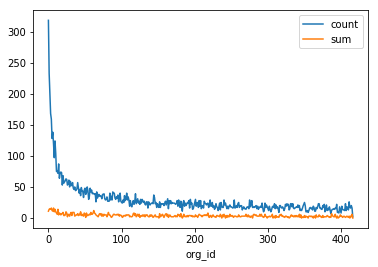

In [81]:
plt.show()

In [82]:
org_df.loc[100:150].plot()

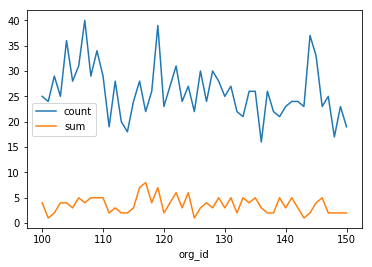

In [83]:
plt.show()

In [84]:
# we dont see any pattern that org id is affected user's adoption
all_df.drop(["org_id"],inplace=True,axis=1)

In [85]:
# creation time should be a number to be used as feature
all_df.creation_time = [datetime.strptime(item,"%Y-%m-%d %H:%M:%S") for item in all_df.creation_time]
all_df.creation_time = [item.timestamp() for item in all_df.creation_time]

In [86]:
all_df.head(),all_df.shape

(           creation_time creation_source  last_session_creation_time  \
 object_id                                                              
 1           1.398139e+09    GUEST_INVITE                1.398139e+09   
 2           1.384487e+09      ORG_INVITE                1.396238e+09   
 3           1.363735e+09      ORG_INVITE                1.363735e+09   
 4           1.369124e+09    GUEST_INVITE                1.369210e+09   
 5           1.358418e+09    GUEST_INVITE                1.358850e+09   
 
            opted_in_to_mailing_list  enabled_for_marketing_drip  adopted_user  \
 object_id                                                                       
 1                                 1                           0             0   
 2                                 0                           0             1   
 3                                 0                           0             0   
 4                                 0                           0             

In [87]:
# some of the last_session_creation_time are nulls
# would be appropriate if we use creation_time to fill up nulls
all_df.last_session_creation_time.fillna(all_df.creation_time,inplace=True)

In [88]:
# now we should convert the creation_source categorical variable into numerical values

In [89]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(all_df.creation_source.values)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded.shape,onehot_encoded)

(11999, 5) [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [90]:
label_encoder.classes_

array(['GUEST_INVITE', 'ORG_INVITE', 'PERSONAL_PROJECTS', 'SIGNUP',
       'SIGNUP_GOOGLE_AUTH'], dtype=object)

In [91]:
creation_df = pd.DataFrame(onehot_encoded,columns=[label_encoder.classes_],dtype='int64',index=all_df.index)

In [92]:
creation_df.head(),creation_df.shape

(          GUEST_INVITE ORG_INVITE PERSONAL_PROJECTS SIGNUP SIGNUP_GOOGLE_AUTH
 object_id                                                                    
 1                    1          0                 0      0                  0
 2                    0          1                 0      0                  0
 3                    0          1                 0      0                  0
 4                    1          0                 0      0                  0
 5                    1          0                 0      0                  0,
 (11999, 5))

In [93]:
final_df = all_df.join(creation_df)

In [94]:
final_df.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user,avg_login_per_month,inviting_user_adopted,"(GUEST_INVITE,)","(ORG_INVITE,)","(PERSONAL_PROJECTS,)","(SIGNUP,)","(SIGNUP_GOOGLE_AUTH,)"
object_id,,,,,,,,,,,,,
1,1.398139e+09,GUEST_INVITE,1.398139e+09,1,0,0,1.0,0,1,0,0,0,0
2,1.384487e+09,ORG_INVITE,1.396238e+09,0,0,1,2.8,0,0,1,0,0,0
3,1.363735e+09,ORG_INVITE,1.363735e+09,0,0,0,1.0,1,0,1,0,0,0
4,1.369124e+09,GUEST_INVITE,1.369210e+09,0,0,0,1.0,1,1,0,0,0,0
5,1.358418e+09,GUEST_INVITE,1.358850e+09,0,0,0,1.0,1,1,0,0,0,0


In [95]:
final_df.columns = [ str(col).replace(",)","") for col in final_df.columns.values]

In [96]:
final_df.columns = [ str(col).replace("(","").lower() for col in final_df.columns.values]

In [97]:
final_df.columns

Index(['creation_time', 'creation_source', 'last_session_creation_time',
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'adopted_user', 'avg_login_per_month', 'inviting_user_adopted',
       ''guest_invite'', ''org_invite'', ''personal_projects'', ''signup'',
       ''signup_google_auth''],
      dtype='object')

In [98]:
final_df.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user,avg_login_per_month,inviting_user_adopted,'guest_invite','org_invite','personal_projects','signup','signup_google_auth'
object_id,,,,,,,,,,,,,
1,1.398139e+09,GUEST_INVITE,1.398139e+09,1,0,0,1.0,0,1,0,0,0,0
2,1.384487e+09,ORG_INVITE,1.396238e+09,0,0,1,2.8,0,0,1,0,0,0
3,1.363735e+09,ORG_INVITE,1.363735e+09,0,0,0,1.0,1,0,1,0,0,0
4,1.369124e+09,GUEST_INVITE,1.369210e+09,0,0,0,1.0,1,1,0,0,0,0
5,1.358418e+09,GUEST_INVITE,1.358850e+09,0,0,0,1.0,1,1,0,0,0,0


In [99]:
final_df.drop(["creation_source"],axis=1,inplace=True)

In [100]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11999 entries, 1 to 11999
Data columns (total 12 columns):
creation_time                 11999 non-null float64
last_session_creation_time    11999 non-null float64
opted_in_to_mailing_list      11999 non-null int64
enabled_for_marketing_drip    11999 non-null int64
adopted_user                  11999 non-null int64
avg_login_per_month           11999 non-null float64
inviting_user_adopted         11999 non-null int64
'guest_invite'                11999 non-null int64
'org_invite'                  11999 non-null int64
'personal_projects'           11999 non-null int64
'signup'                      11999 non-null int64
'signup_google_auth'          11999 non-null int64
dtypes: float64(3), int64(9)
memory usage: 1.5 MB


In [102]:
# now we have all the necessary info to predic if a user is adopted or not
# we will explore the data visually first and then fit ML algos

In [101]:
X_train, X_test,y_train, y_test = train_test_split(final_df.drop(["adopted_user"],axis=1),final_df.adopted_user, test_size=0.3,random_state=42)

In [103]:
X_train.shape, X_test.shape,y_train.shape, y_test.shape

((8399, 11), (3600, 11), (8399,), (3600,))

In [697]:
# multinomial bayes
mnb = MultinomialNB()

In [682]:
mnb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [683]:
mnb.score(X_train,y_train)

0.9578521252530063

In [684]:
mnb.score(X_test,y_test)

0.9572222222222222

In [691]:
confusion_matrix(y_pred=mnb.predict(X_test),y_true=y_test)

array([[3123,    4],
       [ 150,  323]])

In [693]:
# support vector mahcine
svc = SVC()

In [694]:
svc.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [695]:
svc.score(X_train,y_train)

1.0

In [696]:
svc.score(X_test,y_test)

0.8686111111111111

In [711]:
# random forest
rfc = RandomForestClassifier(n_estimators=100,max_features=4)
rfc = rfc.fit(X_train,y_train) 

In [712]:
rfc.score(X_train,y_train)

1.0

In [713]:
rfc.score(X_test,y_test)

0.9855555555555555

In [715]:
confusion_matrix(y_pred=rfc.predict(X_test),y_true=y_test)

array([[3112,   15],
       [  37,  436]])

In [718]:
rfc.feature_importances_

array([0.07572657, 0.23970808, 0.00306603, 0.00281788, 0.6631338 ,
       0.00324931, 0.00233654, 0.0028893 , 0.00275026, 0.00237464,
       0.00194759])

In [734]:
# let us add back the org_id feature and see

In [739]:
org_id_df = pd.DataFrame(data=users_df.org_id.values, index=users_df.object_id,columns=["org_id"])

In [740]:
final_with_org_df  = final_df.join(org_id_df)

In [741]:
final_with_org_df.head()

,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user,avg_login_per_month,inviting_user_adopted,'guest_invite','org_invite','personal_projects','signup','signup_google_auth',org_id
object_id,,,,,,,,,,,,,
1,1.398139e+09,1.398139e+09,1,0,0,1.0,0,1,0,0,0,0,11
2,1.384487e+09,1.396238e+09,0,0,1,2.8,0,0,1,0,0,0,1
3,1.363735e+09,1.363735e+09,0,0,0,1.0,1,0,1,0,0,0,94
4,1.369124e+09,1.369210e+09,0,0,0,1.0,1,1,0,0,0,0,1
5,1.358418e+09,1.358850e+09,0,0,0,1.0,1,1,0,0,0,0,193


In [759]:
X_train, X_test,y_train, y_test = train_test_split(final_with_org_df.drop(["adopted_user"],axis=1),final_with_org_df.adopted_user, test_size=0.3,random_state=42)

In [760]:
# random forest
rfc2 = RandomForestClassifier(n_estimators=100,max_features=5)
rfc2 = rfc2.fit(X_train,y_train) 

In [761]:
rfc2.score(X_train,y_train)

1.0

In [762]:
rfc2.score(X_test,y_test)

0.9858333333333333

In [764]:
rfc2.feature_importances_

array([0.05908719, 0.21111527, 0.00295027, 0.00209144, 0.68796831,
       0.00294771, 0.00209032, 0.00254527, 0.00250419, 0.00208819,
       0.00192787, 0.02268397])

In [751]:
# Ideally org_id is not a numerical feature its categorical so we may try to do that as well

In [752]:
label_encoder2 = LabelEncoder()
integer_encoded2 = label_encoder2.fit_transform(final_with_org_df.org_id.values)

onehot_encoder2 = OneHotEncoder(sparse=False)
integer_encoded2 = integer_encoded2.reshape(len(integer_encoded2), 1)
onehot_encoded2 = onehot_encoder2.fit_transform(integer_encoded2)
print(onehot_encoded2.shape,onehot_encoded2)

(11999, 417) [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [753]:
label_encoder2.classes_

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [754]:
org_cat_df = pd.DataFrame(onehot_encoded2,columns=[label_encoder2.classes_],dtype='int64',index=final_with_org_df.index)

org_cat_df.head()

,0,1,2,3,4,5,6,7,8,9,...,407,408,409,410,411,412,413,414,415,416
object_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [755]:
final_org_cat_df = final_with_org_df.join(org_cat_df)

In [756]:
final_org_cat_df.drop(["org_id"],axis=1,inplace=True)

In [757]:
final_org_cat_df.head()

,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user,avg_login_per_month,inviting_user_adopted,'guest_invite','org_invite','personal_projects',...,"(407,)","(408,)","(409,)","(410,)","(411,)","(412,)","(413,)","(414,)","(415,)","(416,)"
object_id,,,,,,,,,,,,,,,,,,,,,
1,1.398139e+09,1.398139e+09,1,0,0,1.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.384487e+09,1.396238e+09,0,0,1,2.8,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1.363735e+09,1.363735e+09,0,0,0,1.0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1.369124e+09,1.369210e+09,0,0,0,1.0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1.358418e+09,1.358850e+09,0,0,0,1.0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [797]:
# random forest with org cat variable included
X_train, X_test,y_train, y_test = train_test_split(final_org_cat_df.drop(["adopted_user"],axis=1),final_org_cat_df.adopted_user, test_size=0.3,random_state=42)

In [803]:
# random forest
rfc3 = RandomForestClassifier(n_estimators=1000,max_features=20,random_state=42)
rfc3

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=20, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [804]:
rfc3 = rfc3.fit(X_train,y_train) 

In [805]:
rfc3.score(X_train,y_train)

1.0

In [806]:
rfc3.score(X_test,y_test)

0.9825

In [773]:
rfc3.feature_importances_

array([8.22522812e-02, 2.92876556e-01, 6.81383534e-03, 5.43812095e-03,
       4.41875958e-01, 5.32850935e-03, 5.00400650e-03, 6.14227894e-03,
       4.64613202e-03, 4.38769548e-03, 4.00236339e-03, 1.18298057e-03,
       4.51527400e-04, 5.33089734e-04, 4.23496204e-04, 6.69151741e-04,
       4.27307418e-04, 9.78436169e-04, 5.79826883e-04, 7.97745030e-04,
       7.18113159e-04, 4.29373873e-04, 4.47715973e-04, 3.79571630e-04,
       7.30654949e-04, 3.85510698e-04, 3.29795006e-04, 4.05681350e-04,
       3.58208726e-04, 4.39100946e-04, 1.06973509e-03, 4.58964281e-04,
       1.37651532e-04, 5.28430592e-04, 5.93631863e-04, 6.12876092e-04,
       4.40999191e-04, 4.23125727e-04, 4.90664813e-04, 3.17474604e-04,
       3.24398519e-04, 3.66067207e-04, 1.03577162e-03, 2.80659072e-04,
       3.85570095e-04, 4.71610166e-04, 7.35142058e-04, 2.31442969e-04,
       7.73960338e-04, 6.67713100e-04, 4.97537370e-04, 5.03212689e-04,
       2.35865151e-04, 1.88633145e-04, 2.66450925e-04, 6.30826174e-04,
      

In [780]:
# Let use grid search to find best params

In [808]:
rfc4 = RandomForestClassifier(random_state=42)
gcv = GridSearchCV(cv=5,estimator=rfc4,param_grid={'n_estimators':[1000], 'max_features': [20,25], 'max_depth':[10,None]},scoring='accuracy')

In [809]:
gcv

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1000], 'max_features': [20, 25], 'max_depth': [10, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [810]:
gcv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1000], 'max_features': [20, 25], 'max_depth': [10, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [811]:
gcv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=25, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [812]:
gcv.best_estimator_.score(X_train,y_train)

1.0

In [813]:
gcv.best_estimator_.score(X_test,y_test)

0.9830555555555556

In [ ]:
# as seen above if org_id is included as numerical feature it increases the accuracy of the model but not so much if 
# it is included as categorical feature
# wondering why would that be ...is it because one feature is converted to so many and it overall makes the model worse
# by dampening the effect of other important features
# including org_id as numerical feature doesn't seem right
# need to investigate further


In [108]:
# Let us remove avg_login_per_month feature
# This feature was caculated using the same data used for finding the adopted user 

X_train_2 = X_train.drop(["avg_login_per_month"],axis=1)
X_test_2 = X_test.drop(["avg_login_per_month"],axis=1)

In [110]:
X_train_2.head()

,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,inviting_user_adopted,'guest_invite','org_invite','personal_projects','signup','signup_google_auth'
object_id,,,,,,,,,,
7730,1.341567e+09,1.341567e+09,0,0,0,0,1,0,0,0
3547,1.359288e+09,1.359548e+09,1,1,0,0,1,0,0,0
3528,1.357939e+09,1.358112e+09,0,0,0,0,1,0,0,0
10159,1.360455e+09,1.401495e+09,0,0,0,0,0,0,0,1
6960,1.357891e+09,1.357891e+09,0,0,0,0,0,0,1,0


In [112]:
gbc = GradientBoostingClassifier(n_estimators=100,random_state=42)

In [113]:
gbc.fit(X_train_2,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [114]:
gbc.score(X_test_2,y_test)

0.9744444444444444

In [115]:
gbc.score(X_train_2,y_train)

0.9777354446957971

In [120]:
y_pred=gbc.predict(X_test_2)

In [121]:
print(classification_report(y_pred=y_pred,y_true=y_test))

             precision    recall  f1-score   support

          0       0.98      0.99      0.99      3127
          1       0.94      0.86      0.90       473

avg / total       0.97      0.97      0.97      3600



In [122]:
y_pred.sum()

429

In [123]:
gbc.feature_importances_

array([4.00598219e-01, 5.76739304e-01, 2.99751579e-03, 1.00239222e-03,
       7.63687125e-03, 1.35253573e-04, 1.81149407e-03, 1.91342595e-05,
       3.75075812e-05, 9.02230795e-03])

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

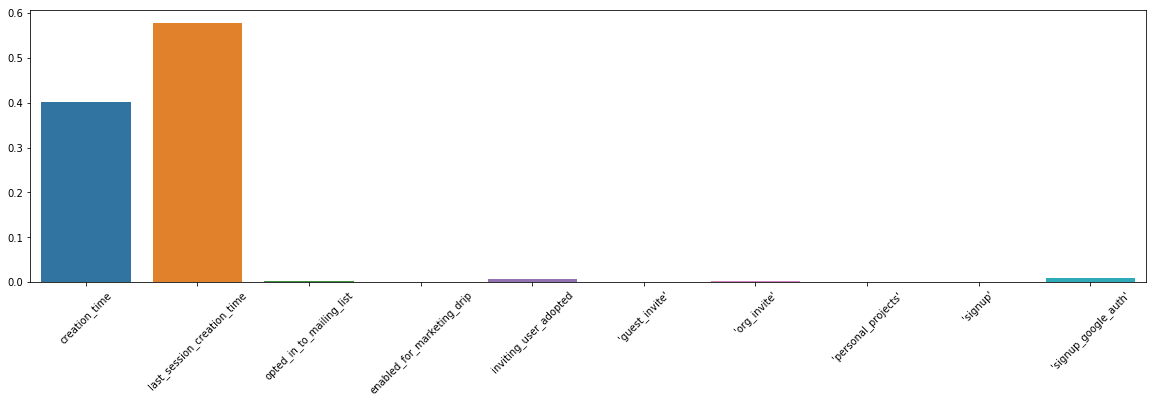

In [160]:
plt.figure(figsize=(20,5))
sns.barplot(X_train_2.columns,gbc.feature_importances_)
plt.xticks(rotation=45)

In [175]:
# Let us remove avg_login_per_month feature
# This feature was caculated using the same data used for finding the adopted user 

X_train_3 = X_train.drop(["avg_login_per_month","enabled_for_marketing_drip","'guest_invite'","'personal_projects'","'signup'"],axis=1)
X_test_3 = X_test.drop(["avg_login_per_month","enabled_for_marketing_drip","'guest_invite'","'personal_projects'","'signup'"],axis=1)

In [176]:
gbc2 = GradientBoostingClassifier(n_estimators=100,random_state=42)

In [177]:
gbc2.fit(X_train_3,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [178]:
gbc2.score(X_test_3,y_test)

0.9755555555555555

In [179]:
gbc2.score(X_train_3,y_train)

0.9778545064888677

In [180]:
y_pred2=gbc2.predict(X_test_3)

In [181]:
print(classification_report(y_pred=y_pred2,y_true=y_test))

             precision    recall  f1-score   support

          0       0.98      0.99      0.99      3127
          1       0.95      0.86      0.90       473

avg / total       0.98      0.98      0.98      3600



In [182]:
y_pred2.sum()

429

In [183]:
# As can be seen this model is not worse

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

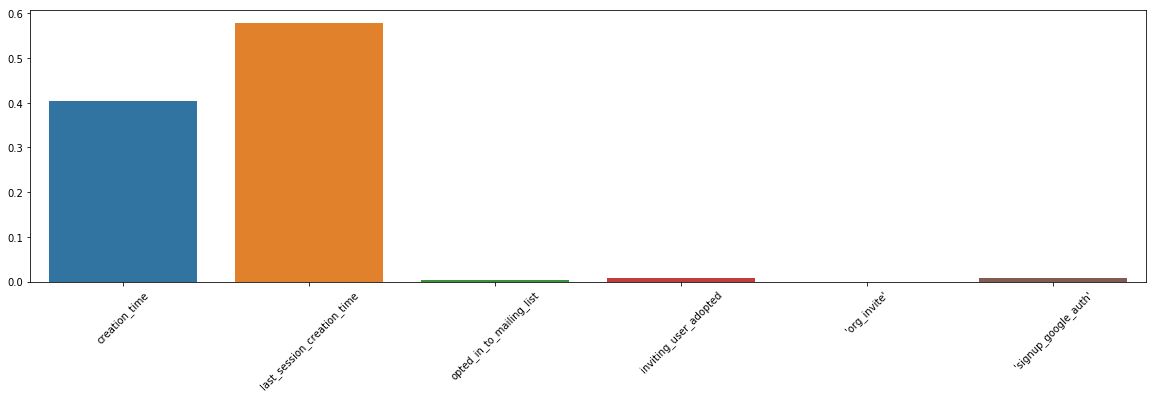

In [185]:
plt.figure(figsize=(20,5))
sns.barplot(X_train_3.columns,gbc2.feature_importances_)
plt.xticks(rotation=45)

In [186]:
X_train_3.columns

Index(['creation_time', 'last_session_creation_time',
       'opted_in_to_mailing_list', 'inviting_user_adopted', ''org_invite'',
       ''signup_google_auth''],
      dtype='object')

### Summary and Conclusion

We first calculated the adopted user based on the given criteria.

We explored and visualized the data to find out what might be good features to predicted if the user was adopted or not. We built various models by removing/adding certain features.

In the end we found the minimal model that provides accuracy of 95% i.e. for any given new data point we will predict correct result 95% of the times. The most important features are:
<b>
'last_session_creation_time', 'creation_time', 'opted_in_to_mailing_list', 'inviting_user_adopted', 'org_invite',  'signup_google_auth'
</b>